- We will write a full pipeline for learning node embeddings. We will go through the following 3 steps:
  1. We will load a classic graph in network science, the `Karate Club Network`. We will explore multiple graph statistics for that graph.
  2. We will then work together to tranform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.
  3. Finally, we will finish the 1st learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk/node2vec algorithms.

## 1 Graph Basics
- We will load a classif graph in network science, the `Karate Club Network`. We will explore multiple graph statistics for that graph.

In [1]:
import networkx as nx

The `karate club network` is a graph which describes a social network of 34 members of a karate club and documents links between members whoe interacted outside the club.

In [2]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

In [3]:
print(G)

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


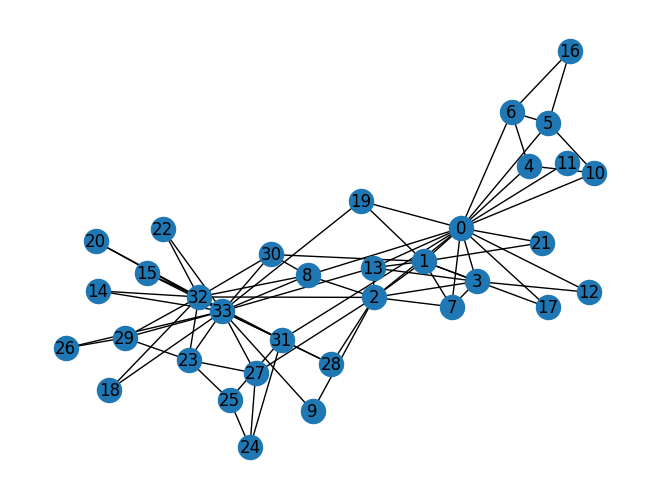

In [4]:
# Visualize the graph
nx.draw(G, with_labels=True)

- What is the averge degree of the karate club network?

In [24]:
def average_degree(num_edges, num_nodes):
  avg_degree = 0
  avg_degree = round(2*num_edges/num_nodes)
  return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print(f"Average degree of karate club network is {avg_degree:.3f}")

Average degree of karate club network is 5.000


- What is the average clustering coefficient of the karate club network
  - A clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.
  - If node A is connected to node B and node B is connected to node C, the probability that node A will also be connected to node C is increased.
  - The clusterinc coefficient in graph measures how connected a node's neighbors are to each other, indicating the tendency for nodes to form tight grouprs or clusters.
  - It ranges from 0 (no connections) to a (a fully connected clique)
  - There are local (for a single node) and global (averge of the whole graph).
  - Local clustering
    - How likely are 2 of a node's friends (neighbors) to also be friends?
    - 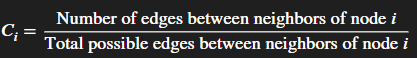
  - Global clustering
    - An overall measure of clusteinr in the entire graph.
    - The average of the local clustering coefficiets for all nodes in the graph.

In [25]:
def average_clustering_coffecient(G):
  avg_cluster_coef = 0
  avg_cluster_coef = nx.average_clustering(G)
  avg_cluster_coef = round(avg_cluster_coef, 2)
  return avg_cluster_coef

avg_cluster_coef = average_clustering_coffecient(G)
print(f'Average clustering coefficient of karate club network is {avg_cluster_coef}')

Average clustering coefficient of karate club network is 0.57


- what is the PageRank value for node 0 (node with id 0) after one PageRank iteration
  - Page Rank measures importance of nodes in a graph using the link structure of the web. A “vote” from an important page is worth more. Specifically, if  a page $i$ with importance $r_i$ has $d_i$ out-links, then each link gets $\frac{r_i}{d_i}$ votes. Thus, the importance of a Page $j$, represented as $r_j$ is the sum of the votes on its in links.
$$r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i}$$, where $d_i$ is the out degree of node $i$.
  - The PageRank algorithm (used by Google) outputs a probability distribution which represent the likelihood of a random surfer clicking on links will arrive at any particular page. At each time step, the random surfer has 2 options:
    1. With prob. $\beta$, follow a link at random
    2. With prob. $1- \beta$, jump to a random page
  - Thus, the importance of a particular page is calculated with the following PageRank equation:
 $$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$$



In [36]:
def one_iter_pagerank(G, beta, r0, node_id):
  # Implement the function that takes a nx.Graph, beta, r0 and node id
  # The return value r1 is one interaction pageRank value for the input node

  r1 = beta * sum(r0/G.degree[neighbor] for neighbor in G.neighbors(node_id))
  r1 += (1-beta)/G.number_of_nodes()
  r1 = round(r1, 2)

  return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print(f'PageRank value for node {node} after one iteration is {r1}')

PageRank value for node 0 after one iteration is 0.13


- What is the (raw) closeness centrality for the karate club network 5?
  - Closness centrality measures how quickly a node can reach all other nodes in a network, calculated as the inverse of the average shortest path distance to every other nodel
  - nodes with high closensss are efficient at spreading information or resources because they are centrally located and have short hops to everyone else.
  - The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [53]:
from os import close
def closeness_centrality(G, node=5):
  # Implement the function that calculates closeness centrality for a node in karate club network.
  # G is the input karate club and node is the node id in the graph.

  closeness = 0

  # 1. We can use neyworkx closeness centrality function
  # 2. Notice that entworkx closeness centrality returns the noramalized closensss ditectly,
  # whichis different from the raw (unnormalized)

  path_length_total = 0
  for path in list(nx.single_source_shortest_path(testingG, 0).values())[1:]:
    path_length_total += len(path) - 1

  closeness = 1/path_length_total
  closeness = round(closeness, 2)
  return closeness
node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.1


## 2. Graph to Tensor
- We will then work together to transform the graph G into a PyTorch, so that we can perform machine learning over the graph.

In [54]:
import torch
print(torch.__version__)

2.9.0+cpu


#### PyTorch tensor basics
- We can generate PyTorch tensor with all zeros, ones or random values.

In [55]:
ones = torch.ones(3, 4)
ones

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [56]:
zeros = torch.zeros(3, 4)
zeros

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [57]:
random_tensor = torch.rand(3, 4)
random_tensor

tensor([[0.7067, 0.9291, 0.5567, 0.0483],
        [0.8239, 0.1693, 0.6888, 0.8783],
        [0.8900, 0.3632, 0.5484, 0.1133]])

In [58]:
ones.shape, zeros.shape, random_tensor.shape

(torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4]))

In [61]:
# Create a 3x4 tensor with all 32 bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
zeros.dtype

torch.float32

- Get the edge list of the karate club network and transform it into torch.LongTensor. What is the torch.sum value of `pos_edge_index` tensor?

In [74]:
def graph_to_edge_list(G):
  # Returns the edge list of an nx.Graph.
  # The returned edge_list should be a list of tuples whwre each typle is tuple representing\
  # an edge connected by two nodes

  edge_list = []

  for edge in G.edges():
    edge_list.append(edge)
  return edge_list

def edge_list_to_tensor(edge_list):
  edge_index = torch.tensor(edge_list, dtype=torch.long)
  edge_index = edge_index.T
  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


- Please implement following function that samples negative edges. Then answer which edges (edge_1 to edge_5) are the negative edges in the karate clube network?
  - 'Negative' edges refer to the edges/links that do not exist in the graph. The term 'negative' is borrowed fromm 'negative sampling' in link prediction. It has noting to do with the edge weights.
  - For example, given an edge (src, dst). We should check that neither (src, dst) nor (dst, src) are edges in the graph. If these hold true, then it is a negative edge.

In [94]:
import random

def sample_negative_edges(G, num_neg_samples):
  # Implement the function that retturns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples.
  # We do not need to consider the corner case when the number of possible nagative edges is
  # less than num_neg_samples. Self loops should not be considered as either a positive or
  # negative edge.

  neg_edge_list = []
  visited = set()
  for u in G.nodes():
    for v in G.nodes():
      if u >= v:
        continue
      if (u, v) in post_edge_list or (v, u) in post_edge_list:
        continue
      if (u, v) in visited or (v, u) in visited:
        continue
      visited.add((u, v))
      visited.add((v, u))
      neg_edge_list.append((u, v))
      if len(neg_edge_list) == num_neg_samples:
        return neg_edge_list

  return neg_edge_list


# sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))
# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))


# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

def can_be_negative(G, edge):
  # TODO: Implement the function that tests if an edge is a negative
  # edge in graph G.

  is_negative = False
  u, v = edge
  if (u, v) in neg_edge_list or (v, u) in neg_edge_list:
    is_negative = True

  return is_negative

print(f"Edge 1 can be a negative edge: {can_be_negative(G, edge_1)}")
print(f"Edge 2 can be a negative edge: {can_be_negative(G, edge_2)}")
print(f"Edge 3 can be a negative edge: {can_be_negative(G, edge_3)}")
print(f"Edge 4 can be a negative edge: {can_be_negative(G, edge_4)}")
print(f"Edge 5 can be a negative edge: {can_be_negative(G, edge_5)}")

The neg_edge_index tensor has shape torch.Size([2, 78])
Edge 1 can be a negative edge: False
Edge 2 can be a negative edge: True
Edge 3 can be a negative edge: False
Edge 4 can be a negative edge: False
Edge 5 can be a negative edge: True


## 3. Node embedding Learning
- We will finish the 1st learning algorithm on graph: a node embedding model

In [95]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

- To write our own node embedding learning methods, we'll heavily use the `nn.Embedding` module in PyTorch

In [96]:
# Initialize an emebdding layer
# Suppose we want to have embedding for 4 times (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print(f'Sample embedding layer: {emb_sample}')

Sample embedding layer: Embedding(4, 8)


- We can select items from the embedding matrix, by using Tensor indices

In [97]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

tensor([[ 0.6581, -0.6016, -1.1454,  1.5026,  2.2152, -0.0592,  1.2609, -1.0138]],
       grad_fn=<EmbeddingBackward0>)


In [98]:
# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

tensor([[ 0.6581, -0.6016, -1.1454,  1.5026,  2.2152, -0.0592,  1.2609, -1.0138],
        [ 2.1603, -0.3969,  0.0533, -1.6550, -0.2198, -1.2856,  0.7643, -0.8723]],
       grad_fn=<EmbeddingBackward0>)


In [99]:
# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

torch.Size([4, 8])


In [100]:
# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let;s check if the emb is indded intializes
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


- Now, its time to create node embedding matrix for the graph.
  - We want to have 16 dimensional vector for each node in the karate club network.
  - We want to initalize the matrix under uniform distribution, in the range of [0, 1).

In [105]:
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # Implement this fuction that will create the node embedding matrix
  # A torch.nn.embedding layer will be returned,
  # the weight matrix of returned layer should be initalized under uniform distribution

  emb = nn.Embedding(num_embeddings=num_nodes, embedding_dim=embedding_dim)
  emb.weight.data = torch.rand(num_nodes, embedding_dim)

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


#### Visualize the initial node embeddings
- One good way to understand an embedding matrix, is to visuaize it in a 2D space. We 1st do PCA to reduce the dimensionality of embeddings to a 2D space. Then we visualize each point, colored by the community it belong to

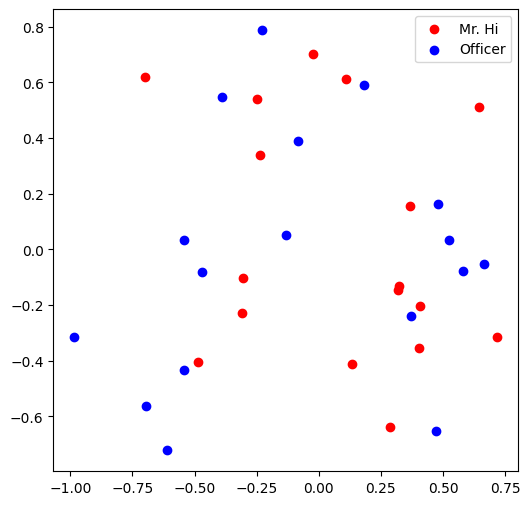

In [106]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

- Training the embeedding! What is the best performance we can get?
  - We want to optimize our embeddings for the task of classifying edges as positibe or negative. Given an edge and the embeddings for each node, the dot product of the embeddings, followed by a sigmoid, should give us the likehood of that edge being either postive (sigmoid > 0.5) or negative (sigmoid < 0.5)

In [115]:
from torch.optim import SGD
import numpy as np

def accuracy(pred, label):
  # Implement the accuracy function. This function takes the pred tensor (the resulting
  # tensor after sigmod and the label tensor. Predicted value greater than 0.5 will be
  # classified as label 1 else it will be classified as label 0.

  accu = 0.0

  pred = [1 if item > 0.5 else 0 for item in pred]
  num_match = (np.array(pred) == np.array(label)).sum()

  accu = num_match / len(pred)

  return accu


def train(emb, loss_fn, train_label, train_edge):
  # Train the embedding layer here, we can also change epochs and learning rate.
  # In general, we need to implement
  # 1. Get the embeddings between each node pair
  # 3. Feed the dot product result in sigmoid
  # 4. Feed the sigmoid output into the loss_fn
  # 5. Print both loss and accuracy of each epoch
  # 6. Update the embedddigs using the loss and optimizer
  # The loss should decrease during training

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)
  sigmoid = nn.Sigmoid()

  for i in range(epochs):
    optimizer.zero_grad()

    u, v = train_edge[0], train_edge[1]

    # Get the embeddings between each node pair
    emb_set_u = emb(u)
    emb_set_v = emb(v)

    # dot product the embeddings betwee each node pair
    dot_prod = torch.sum(emb_set_u * emb_set_v, dim=-1)

    # Feed the  dot product result into sigmoid
    sig = sigmoid(dot_prod)

    # Feed the sigmoid output into the loss_fn
    loss = loss_fn(sig, train_label)

    loss.backward() # Derive gradients
    optimizer.step() # Update parameters based on gradients

    print(f'Epoch {i}: Loss {loss}, Accuracy {accuracy(sig, train_label)}')



  return emb

loss_fn = nn.BCELoss()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, train_label, train_edge)

torch.Size([2, 78])
torch.Size([2, 156])
Epoch 0: Loss 2.0307705402374268, Accuracy 0.5
Epoch 1: Loss 2.003140687942505, Accuracy 0.5
Epoch 2: Loss 1.9512161016464233, Accuracy 0.5
Epoch 3: Loss 1.8784946203231812, Accuracy 0.5
Epoch 4: Loss 1.788571834564209, Accuracy 0.5
Epoch 5: Loss 1.6851061582565308, Accuracy 0.5
Epoch 6: Loss 1.5717999935150146, Accuracy 0.5
Epoch 7: Loss 1.452378749847412, Accuracy 0.5
Epoch 8: Loss 1.3305433988571167, Accuracy 0.5
Epoch 9: Loss 1.2098853588104248, Accuracy 0.5
Epoch 10: Loss 1.0937565565109253, Accuracy 0.5
Epoch 11: Loss 0.9851102828979492, Accuracy 0.4935897435897436
Epoch 12: Loss 0.8863380551338196, Accuracy 0.5192307692307693
Epoch 13: Loss 0.7991383671760559, Accuracy 0.5705128205128205
Epoch 14: Loss 0.7244343161582947, Accuracy 0.5705128205128205
Epoch 15: Loss 0.6623414754867554, Accuracy 0.5833333333333334
Epoch 16: Loss 0.6122063994407654, Accuracy 0.6410256410256411
Epoch 17: Loss 0.5727501511573792, Accuracy 0.6923076923076923
Epo

Embedding(34, 16)

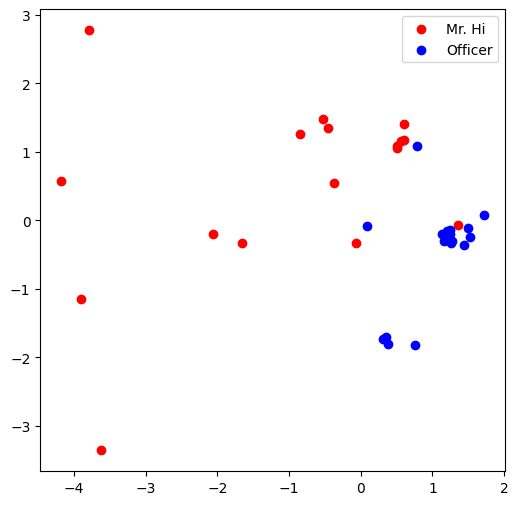

In [116]:
visualize_emb(emb)

In [108]:
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
train_edge[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
         4,  5,  5,  5,  6,  8,  8,  8,  9, 13, 14, 14, 15, 15, 18, 18, 19, 20,
        20, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 28, 28, 29,
        29, 30, 30, 31, 31, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3])